<a href="https://colab.research.google.com/github/kabirodavies/Data-Projects/blob/main/House%20Price%20Analysis/EDA/Housing_Market_California_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Study house price of single family residential property type in the State of California (CA) from 2018-01-01 to 2022.

## Importing Libraries

In [27]:
#Import all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, normalize, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as hc
from sklearn.cluster import AgglomerativeClustering

# Load the data

*   Housing Market Data From Redfin.
*   Redfin is a real estate brokerage, meaning we have direct access to data from local multiple listing services, as well as insight from our real estate agents across the country.




In [3]:
house_url = 'https://redfin-public-data.s3.us-west-2.amazonaws.com/redfin_market_tracker/zip_code_market_tracker.tsv000.gz'

house_ori = pd.read_csv(house_url, compression='gzip', sep='\t', quotechar='"')
house = house_ori.copy()


# Exploratory Data Analysis

Running head gives us a peek of our dataset. Although this doesn’t really tell us much about our data besides showing us how the data looks like.

In [4]:
house.head()

,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,state,...,sold_above_list_yoy,price_drops,price_drops_mom,price_drops_yoy,off_market_in_two_weeks,off_market_in_two_weeks_mom,off_market_in_two_weeks_yoy,parent_metro_region,parent_metro_region_metro_code,last_updated
0,2022-01-01,2022-03-31,90,zip code,2,28652,f,Zip Code: 66431,NaN,Kansas,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,"Topeka, KS",45820,2022-09-11 14:46:03
1,2020-01-01,2020-03-31,90,zip code,2,35743,f,Zip Code: 83713,NaN,Idaho,...,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,"Boise City, ID",14260,2022-09-11 14:46:03
2,2017-11-01,2018-01-31,90,zip code,2,38464,f,Zip Code: 92705,NaN,California,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Anaheim, CA",11244,2022-09-11 14:46:03
3,2014-04-01,2014-06-30,90,zip code,2,8432,f,Zip Code: 21208,NaN,Maryland,...,0.026786,NaN,NaN,NaN,0.636364,0.454545,0.436364,"Baltimore, MD",12580,2022-09-11 14:46:03
4,2012-02-01,2012-04-30,90,zip code,2,39521,f,Zip Code: 95301,NaN,California,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Merced, CA",32900,2022-09-11 14:46:03


In [ ]:
house.shape

# Data info
Calling info() on our dataset tells us tons of information about our data frame like the shape (rows, columns), the data type of our features, and the memory usage.

In [ ]:
house.info()

# Data Type
Separating our features into numerical and categorical early on is useful.

In [5]:
cat_df = house.select_dtypes(include=['object'])
num_df = house.select_dtypes(exclude=['object'])

def printColumnTypes(non_numeric_df, numeric_df):
    '''separates non-numeric and numeric columns'''
    print("Non-Numeric columns:")
    for col in non_numeric_df:
        print(f"{col}")
    print("")
    print("Numeric columns:")
    for col in numeric_df:
        print(f"{col}")
        
printColumnTypes(cat_df, num_df)

Non-Numeric columns:
period_begin
period_end
region_type
is_seasonally_adjusted
region
state
state_code
property_type
parent_metro_region
last_updated

Numeric columns:
period_duration
region_type_id
table_id
city
property_type_id
median_sale_price
median_sale_price_mom
median_sale_price_yoy
median_list_price
median_list_price_mom
median_list_price_yoy
median_ppsf
median_ppsf_mom
median_ppsf_yoy
median_list_ppsf
median_list_ppsf_mom
median_list_ppsf_yoy
homes_sold
homes_sold_mom
homes_sold_yoy
pending_sales
pending_sales_mom
pending_sales_yoy
new_listings
new_listings_mom
new_listings_yoy
inventory
inventory_mom
inventory_yoy
months_of_supply
months_of_supply_mom
months_of_supply_yoy
median_dom
median_dom_mom
median_dom_yoy
avg_sale_to_list
avg_sale_to_list_mom
avg_sale_to_list_yoy
sold_above_list
sold_above_list_mom
sold_above_list_yoy
price_drops
price_drops_mom
price_drops_yoy
off_market_in_two_weeks
off_market_in_two_weeks_mom
off_market_in_two_weeks_yoy
parent_metro_region_metro_c

###### Seems like the 'period_begin', 'period_end', and 'city' columns are in the wrong format.

###### Since this is a huge dataset with 6,196,869 rows and 58 columns, we will filter the data to only the State of California for the 'Single Family Residential' property_type' from 2018-01-01. 

## Data Cleaning

In [6]:
# convert the 'period_begin' and 'period_end columns to datetime format
house['period_begin'] = pd.to_datetime(house['period_begin'])
house['period_end'] = pd.to_datetime(house['period_end'])

In [12]:
#Filter the dataframe to only look at single-family properties sold in California (CA) from 2021-01 to 2022-06-01
df_CA = house[(house['period_begin'] >='2018-01-01') & (house['property_type']=='Single Family Residential') & (house['state_code']=='CA')]

In [15]:
# Check new shape
df_CA.shape

(76000, 58)

In [14]:
# Check city column
df_CA['city'].isna().sum()

76000

City column seems to be missing all records, we'll drop it later after checking for other possible columns with similar properties

# Outliers

## Detecting Outliers
1. Boxplots
2. Z-score
3. Inter Quantile Range(IQR)

# Handling Outliers

1. Trimming/removing the outlier
2. Quantile based flooring and capping
3. Mean/Median imputation

# Missing Data
Missing data is common in all kinds of data and is tricky to deal with. Most machine learning techniques do not work with missing values and it has to be addressed early on.

### The two common methods to deal with missing values are

1. Dropping the rows / columns
2. Imputing them based on other observations i.e. the mean or median

## Columns with missing values


In [26]:
def missing_cols(df):
    '''prints out columns with its amount of missing values'''
    total = 0
    for col in df.columns:
        missing_vals = df[col].isnull().sum()
        total += missing_vals
        if missing_vals != 0:
            print(f"{col} => {df[col].isnull().sum()}")
    
    if total == 0:
        print("no missing values left")
            
missing_cols(df_CA)

city => 76000
median_sale_price_mom => 1599
median_sale_price_yoy => 4397
median_list_price => 2655
median_list_price_mom => 4380
median_list_price_yoy => 6569
median_ppsf => 86
median_ppsf_mom => 1678
median_ppsf_yoy => 4461
median_list_ppsf => 2684
median_list_ppsf_mom => 4404
median_list_ppsf_yoy => 6588
homes_sold_mom => 1599
homes_sold_yoy => 4397
pending_sales => 9307
pending_sales_mom => 12985
pending_sales_yoy => 13816
new_listings => 2649
new_listings_mom => 4375
new_listings_yoy => 6566
inventory => 3559
inventory_mom => 5188
inventory_yoy => 7180
months_of_supply => 76000
months_of_supply_mom => 76000
months_of_supply_yoy => 76000
median_dom => 802
median_dom_mom => 2423
median_dom_yoy => 5215
avg_sale_to_list => 15
avg_sale_to_list_mom => 1612
avg_sale_to_list_yoy => 4418
sold_above_list_mom => 1599
sold_above_list_yoy => 4397
price_drops => 76000
price_drops_mom => 76000
price_drops_yoy => 76000
off_market_in_two_weeks => 9307
off_market_in_two_weeks_mom => 12985
off_marke

## Percentage missing

In [17]:
def perc_missing(df):
    '''prints out columns with missing values with its %'''
    for col in df.columns:
        pct = df[col].isna().mean() * 100
        if (pct != 0):
            print('{} => {}%'.format(col, round(pct, 2)))
    
perc_missing(df_CA)

city => 100.0%
median_sale_price_mom => 2.1%
median_sale_price_yoy => 5.79%
median_list_price => 3.49%
median_list_price_mom => 5.76%
median_list_price_yoy => 8.64%
median_ppsf => 0.11%
median_ppsf_mom => 2.21%
median_ppsf_yoy => 5.87%
median_list_ppsf => 3.53%
median_list_ppsf_mom => 5.79%
median_list_ppsf_yoy => 8.67%
homes_sold_mom => 2.1%
homes_sold_yoy => 5.79%
pending_sales => 12.25%
pending_sales_mom => 17.09%
pending_sales_yoy => 18.18%
new_listings => 3.49%
new_listings_mom => 5.76%
new_listings_yoy => 8.64%
inventory => 4.68%
inventory_mom => 6.83%
inventory_yoy => 9.45%
months_of_supply => 100.0%
months_of_supply_mom => 100.0%
months_of_supply_yoy => 100.0%
median_dom => 1.06%
median_dom_mom => 3.19%
median_dom_yoy => 6.86%
avg_sale_to_list => 0.02%
avg_sale_to_list_mom => 2.12%
avg_sale_to_list_yoy => 5.81%
sold_above_list_mom => 2.1%
sold_above_list_yoy => 5.79%
price_drops => 100.0%
price_drops_mom => 100.0%
price_drops_yoy => 100.0%
off_market_in_two_weeks => 12.25%
off_

## Heatmap of missing values


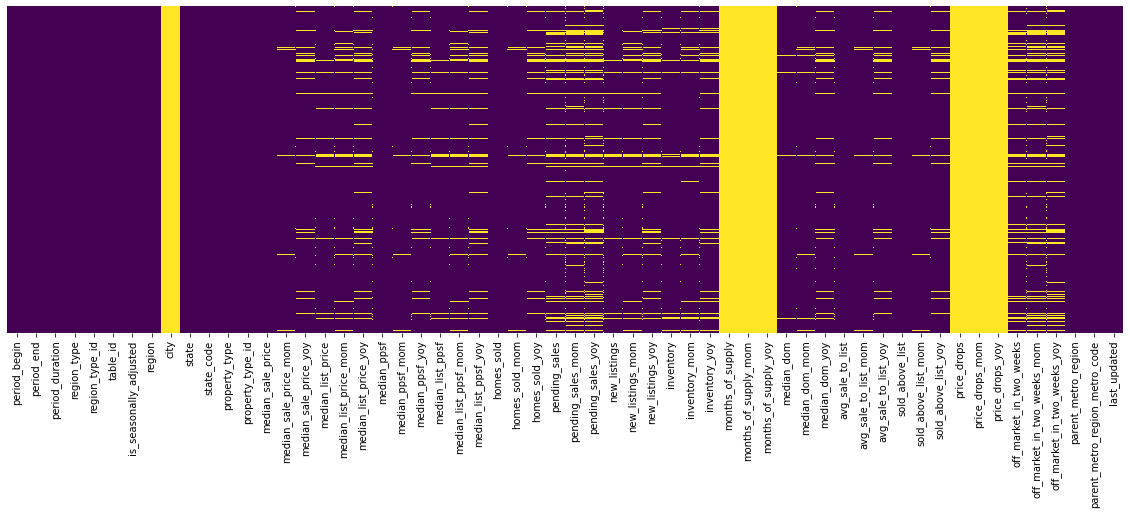

In [32]:
plt.figure(figsize=(20, 6))
sns.heatmap(df_CA.isnull(), yticklabels=False, cmap='viridis', cbar=False)

## Technique to deal with missing values
1. Drop the feature
2. Drop the row
3. Impute the missing value
4. Replace it

In [33]:
df_CA.shape

(76000, 58)

In [35]:
df = df_CA.copy()

In [36]:
# Drop unnecessary columns that are not important
df.dropna(axis=1, thresh = int(0.2*df.shape[0]), inplace=True)

In [37]:
df.shape

(76000, 51)

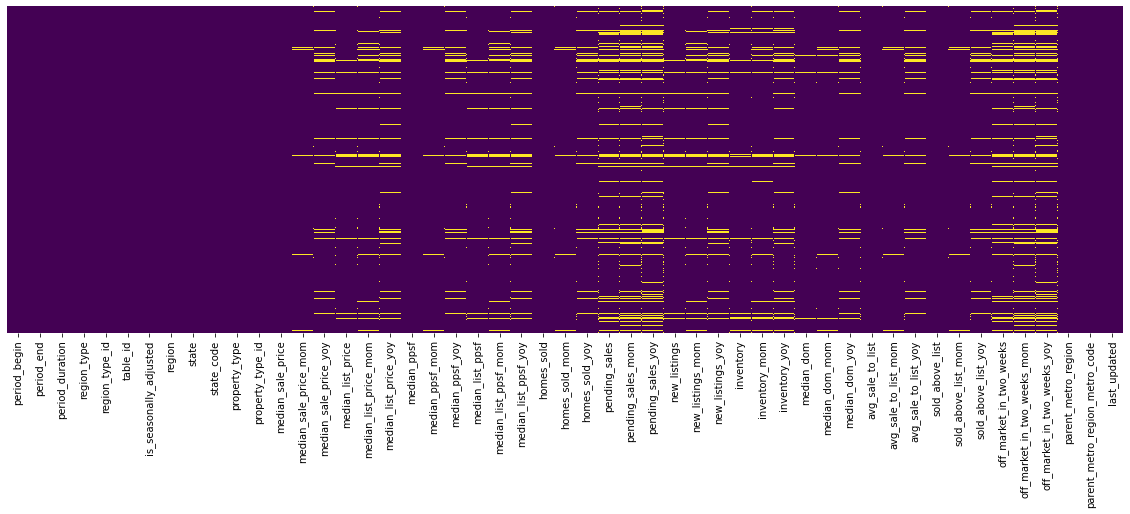

In [38]:
plt.figure(figsize=(20, 6))
sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis', cbar=False)

## Spelling errors in categorical data


## Converting to DateTime

## Duplicates